# Inspired by Medium part 3 explore xview

In [16]:
import numpy as np
import pandas as pd
#import geopandas as gpd
import json
import matplotlib.pyplot as plt

from shapely import wkt
import os

!pip install rasterio
!pip install geopandas
!pip install rioxarray

import rasterio as rio
from rasterio.plot import show
from rasterio.warp import transform_bounds
from rasterio.crs import CRS
from rasterio.mask import mask
import geopandas as gpd
import rioxarray as rxr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.9/20.9 MB 39.2 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 21.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.6/16.6 MB 62.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 84.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.3/53.3 KB 5.4 MB/s eta 0:00:00


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Extract imagery and meta-data

In [3]:
%cd /content/drive/MyDrive/hurricane-harm-herald/data/xBD_data

/content/drive/MyDrive/hurricane-harm-herald/data/xBD_data


In [4]:
# fetch all post disaster json files
import fnmatch
import os

# or list: print([f for f in os.listdir(xbd_json_directory) if fnmatch.fnmatch(f, 'hurricane*post*json')])
def extract_posthurr(which_directory, search_criteria):
  list_of_files = []
  for f in os.listdir(which_directory):
    if fnmatch.fnmatch(f, search_criteria):
      list_of_files.append(f)
  return list_of_files

xbd_json_directory = "/content/drive/MyDrive/hurricane-harm-herald/data/xBD_data/geotiffs/hold/labels"
posthurr_json_files = extract_posthurr(xbd_json_directory,'hurricane*post*.json')

In [5]:
# Which hurricanes do we have?
def hurricane_labels(posthurr_files ):
  disaster_labels = []
  for label in posthurr_files:
    disaster_type = label.split("_")[0]
    #disaster_name = disaster_type.split("_")[1]
    disaster_labels.append(disaster_type)
    #disaster_labels.append([disaster_type, disaster_name])
  return disaster_labels

hurricane_labels = hurricane_labels(posthurr_json_files)
unique_hurricane_labels = list(set(hurricane_labels))
unique_hurricane_labels 


['hurricane-florence',
 'hurricane-matthew',
 'hurricane-harvey',
 'hurricane-michael']

In [6]:
# select specific disaster
disaster_name = unique_hurricane_labels[0]
disaster_name

'hurricane-florence'

In [7]:
!pwd

/content/drive/MyDrive/hurricane-harm-herald/data/xBD_data


In [111]:
# extract all hurricane_florence json files
#json_search_terms = disaster_name + "*post*json"
#florence_json = extract_posthurr(xbd_json_directory, json_search_terms)
xbd_json_directory = "/content/drive/MyDrive/hurricane-harm-herald/data/xBD_data/geotiffs/hold/labels"
florence_json = extract_posthurr(xbd_json_directory, 'hurricane*florence*post*.json')

# extract all hurricane florence image files
xbd_tif_directory = "/content/drive/MyDrive/hurricane-harm-herald/data/xBD_data/geotiffs/hold/images"
#tif_search_terms = disaster_name + "*post*tif"
florence_tif = extract_posthurr(xbd_tif_directory, 'hurricane*florence*post*.tif')

# Start plotting

In [228]:
# Color codes for different damage classes (Joint Damage Scale)
damage_dict = {
    "no-damage": (0, 255, 0, 50),
    "minor-damage": (0, 0, 255, 50),
    "major-damage": (255, 69, 0, 50),
    "destroyed": (255, 0, 0, 50),
    "un-classified": (255, 255, 255, 50)
}

# Color codes for different damage classes (Joint Damage Scale)
classes_dict = {
    "no-damage": 0,
    "minor-damage": 1,
    "major-damage": 2,
    "destroyed": 3,
    "un-classified": 4
}

In [274]:
def extract_metadata(json_link, format, classes_dict):
  json_file = open(json_link)
  json_data = json.load(json_file)
  meta_data = json_data['metadata']
  image_name = meta_data['img_name']
  coordinates = json_data['features']['xy']

  damage_location = []
  damage_dict = {}
  if format == 'point':
      def extract_location(building):
        building_polygon = building['wkt']
        building_coordinates = wkt.loads(building_polygon).centroid.wkt
        return building_coordinates
  if format == 'polygon':
    def extract_location(building):
        building_polygon = building['wkt']
        return building_polygon
  # add exit line if no good answer is given

  for building in coordinates:
    building_loc = extract_location(building)
    damage_class = building['properties']['subtype']
    damage_num = classes_dict[damage_class]
    
    damage_location.append([building_loc, damage_num])
    damage_dict.update({damage_num:building_loc})
  df = GeoDataFrame(damage_location, columns = ['geometry', 'damage class'])
  #print(polygons)
 # d = {'damage class': damage_num, 'geometry': extract_location(building)}
 # gdf = geopandas.GeoDataFrame(d)
  
  return df

In [275]:
from geopandas import GeoDataFrame
json_link = "/content/drive/MyDrive/hurricane-harm-herald/data/xBD_data/geotiffs/hold/labels/" + florence_json[0]
polygon_damage = extract_metadata(json_link, 'polygon', classes_dict)
polygon_damage

,geometry,damage class
0,POLYGON ((247.3120843129568 0.0100522531708349...,2
1,"POLYGON ((126.1624075440996 65.34934444046426,...",1


In [296]:
from osgeo import gdal
import matplotlib.pyplot as plt

In [375]:
from rasterio.plot import show
def plot_image_label(json_label, tif_dir, damage_dict, classes_dict):
  # get information on damage and polygons in pandas dataframe
  polygon_damage = extract_metadata(json_label, 'polygon', classes_dict)

  # plot imagery file
  building_image_path = json_label.replace('labels', 'images').replace('json','tif')
  img = rasterio.open(building_image_path)

  gdal_img = gdal.Open(building_image_path)
  band1 = gdal_img.GetRasterBand(1).ReadAsArray()
  band2 = gdal_img.GetRasterBand(2).ReadAsArray()
  band3 = gdal_img.GetRasterBand(3).ReadAsArray()

  extent=[img.bounds[0], img.bounds[2], img.bounds[1], img.bounds[3]]
  img = np.dstack((band1, band2, band3))
  f = plt.figure()
  plt.imshow(img)
  plt.show()

  polygon_damage['geometry'] = gpd.GeoSeries.from_wkt(polygon_damage['geometry'])
  my_geo_df = gpd.GeoDataFrame(polygon_damage, geometry='geometry')

  my_geo_df.plot(column = "damage class")

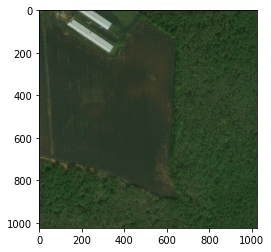

                                            geometry  damage class
0  POLYGON ((247.312 0.010, 340.399 63.534, 317.2...             2
1  POLYGON ((126.162 65.349, 134.332 49.917, 146....             1


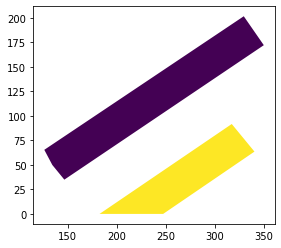

In [374]:
from PIL import Image, ImageDraw

json_dir = "/content/drive/MyDrive/hurricane-harm-herald/data/xBD_data/geotiffs/hold/labels/"
xbd_tif_directory = "/content/drive/MyDrive/hurricane-harm-herald/data/xBD_data/geotiffs/hold/images"
specific_label_file = florence_json[0]
json_label = json_dir + "/" + specific_label_file

plot_image_label(json_label, xbd_tif_directory, damage_dict, classes_dict)

### MAKE THEM ALIGN LOL

# Make the EF dataset

In [343]:
def extract_metadata_points(json_link, classes_dict):
  json_file = open(json_link)
  json_data = json.load(json_file)
  meta_data = json_data['metadata']
  disaster_type = meta_data['disaster']
  capture_date = meta_data['capture_date']

  coordinates = json_data['features']['xy']
  damage_location = []

  def extract_location(building):
    building_polygon = building['wkt']
    building_coordinates = wkt.loads(building_polygon).centroid.wkt
    return building_coordinates

  for building in coordinates:
    building_loc = extract_location(building)
    damage_class = building['properties']['subtype']
    damage_num = classes_dict[damage_class]
    
    damage_location.append([building_loc, damage_num, disaster_type, capture_date])
  df = GeoDataFrame(damage_location, columns = ['geometry', 'damage class', 'disaster name', 'capture date'])
  return df

In [344]:
json_link = "/content/drive/MyDrive/hurricane-harm-herald/data/xBD_data/geotiffs/hold/labels/" + florence_json[0]

extract_metadata_points(json_link, classes_dict)

,geometry,damage class,disaster name,capture date
0,POINT (270.472192671193 39.1967477286612),2,hurricane-florence,2018-09-20T16:04:41.000Z
1,POINT (237.3159744723163 117.9576222367676),1,hurricane-florence,2018-09-20T16:04:41.000Z


In [351]:
def extract_points_damage_allfiles(full_post_hurr_json_files):
  dataframes_list = []
  for file in full_post_hurr_json_files:
    loc_and_damage_df = extract_metadata_points(file, classes_dict)
    dataframes_list.append(loc_and_damage_df)  
  rdf = gpd.GeoDataFrame(pd.concat(dataframes_list, ignore_index=True))
  return rdf

In [388]:
full_post_hurr_json_files = [xbd_json_directory + "/" + i for i in posthurr_json_files]

df_points_post_hurr = extract_points_damage_allfiles(full_post_hurr_json_files)

In [389]:
df_points_post_hurr['capture date'] = pd.to_datetime(meta_data_points_post_hurr['capture date'])

In [390]:
df_points_post_hurr

,geometry,damage class,disaster name,capture date
0,POINT (270.472192671193 39.1967477286612),2,hurricane-florence,2018-09-20 16:04:41+00:00
1,POINT (237.3159744723163 117.9576222367676),1,hurricane-florence,2018-09-20 16:04:41+00:00
2,POINT (918.4385807812326 1010.6264560931927),0,hurricane-michael,2018-10-13 16:48:15+00:00
3,POINT (816.3306268891515 1018.9566968424516),0,hurricane-michael,2018-10-13 16:48:15+00:00
4,POINT (819.1450854852911 878.9166217353865),1,hurricane-michael,2018-10-13 16:48:15+00:00
...,...,...,...,...
23049,POINT (163.2786512160337 991.7472636502039),0,hurricane-florence,2018-09-20 16:04:41+00:00
23050,POINT (211.91524404122964 982.1444131357814),0,hurricane-florence,2018-09-20 16:04:41+00:00
23051,POINT (228.34177690185325 929.3449450927592),0,hurricane-florence,2018-09-20 16:04:41+00:00
23052,POINT (85.28614913360693 1016.2542187816331),0,hurricane-florence,2018-09-20 16:04:41+00:00


## Save new file

In [396]:
%cd /content/drive/MyDrive/hurricane-harm-herald/data/xBD_data/geotiffs/hold/

/content/drive/MyDrive/hurricane-harm-herald/data/xBD_data/geotiffs/hold


In [397]:
df_points_post_hurr.to_pickle("./df_points_posthurr.pkl")

In [398]:
pd.read_pickle("./df_points_posthurr.pkl")

,geometry,damage class,disaster name,capture date
0,POINT (270.472192671193 39.1967477286612),2,hurricane-florence,2018-09-20 16:04:41+00:00
1,POINT (237.3159744723163 117.9576222367676),1,hurricane-florence,2018-09-20 16:04:41+00:00
2,POINT (918.4385807812326 1010.6264560931927),0,hurricane-michael,2018-10-13 16:48:15+00:00
3,POINT (816.3306268891515 1018.9566968424516),0,hurricane-michael,2018-10-13 16:48:15+00:00
4,POINT (819.1450854852911 878.9166217353865),1,hurricane-michael,2018-10-13 16:48:15+00:00
...,...,...,...,...
23049,POINT (163.2786512160337 991.7472636502039),0,hurricane-florence,2018-09-20 16:04:41+00:00
23050,POINT (211.91524404122964 982.1444131357814),0,hurricane-florence,2018-09-20 16:04:41+00:00
23051,POINT (228.34177690185325 929.3449450927592),0,hurricane-florence,2018-09-20 16:04:41+00:00
23052,POINT (85.28614913360693 1016.2542187816331),0,hurricane-florence,2018-09-20 16:04:41+00:00
